In [1]:
import pandas as pd
import re

data = pd.read_csv('data.tsv', sep = '\t', keep_default_na = False, low_memory=False)
data_req = data[['article_title','times_cited_all','times_cited_wos','180_days_usage','since_2013_usage','publication_year','number_of_pages','wos_categories','research_areas','highly_cited_status','hot_paper_status','funding_text']]
pd.options.mode.chained_assignment = None

In [39]:
import dill
dill.dump_session('notebook_env.db') # Save session to dump file

In [11]:
import dill
dill.load_session('notebook_env.db') # Restore sesion from dump file

In [ ]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, SnowballStemmer, PorterStemmer

def delSW(text):
  stop_words = stopwords.words('english')
  stop_words.extend([',','.',';',':','(',')',"'",'s'])
  return [word for word in text if word not in stop_words]

def lem(text):
  wnl = WordNetLemmatizer()
  return [wnl.lemmatize(w) for w in text]

def stem(text):
  array = []
  for word in text:
    stemmer = SnowballStemmer('english')
    word = stemmer.stem(word)
    array.append(word)
  return array

nltk_data = data

# nltk_data['tokened'] = nltk_data.abstract.str.lower().apply(word_tokenize).apply(delSW)
# nltk_data['lemmed'] = nltk_data.tokened.apply(lem)
# nltk_data['stemmed'] = nltk_data.tokened.apply(stem)

nltk_data.to_csv('nltk_data_prepped.tsv', sep="\t")

In [31]:
gensim_data = data.abstract
gensim_data = gensim_data.map(lambda x: re.sub(r'[^\w\s]', '', x))
gensim_data = gensim_data.map(lambda x: x.lower())
gensim_data.head()
gensim_data.to_csv('gensim_data_prepped.tsv', sep="\t")

In [ ]:
nlp = spacy.load("en_core_web_sm")
abstracts_isolated = gensim_data.abst.apply(lambda x: " ".join([y.lemma_ for y in nlp(x)]))

In [339]:
from countrygroups import EUROPEAN_UNION

countries = EUROPEAN_UNION.names
countries.extend(['England','Wales','Scotland','Switzerland','Norway'])
data_calc = data[['article_title','addresses']]
data_calc = data_calc[data_calc.addresses != '']
data_calc['addresses'] = data_calc['addresses'].str.replace(' *\[[^\]]*] ', '')
data_calc['addresses'] = data_calc['addresses'].str.split(';')
data_calc = data_calc.explode('addresses')
# data_calc = data_calc['addresses'].str.extractall(r'(?<=\] )(.*?)(?=\;|$)|(?=^[^\[])(.*?)(?=\;|$)').droplevel(1).drop(labels=1, axis=1)
data_calc['university'] = data_calc['addresses'].str.extract(r'^(.+?),')
data_calc['country'] = data_calc['addresses'].str.extract(r'^.*\, (.*)$')
# data_calc = data_calc[data_calc.groupby(level=0)['country'].transform(lambda x : x.isin(countries).any())]

/var/folders/39/smztn3fx405fkqb1pwdcclm40000gq/T/ipykernel_9052/1148528216.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
  data_calc['addresses'] = data_calc['addresses'].str.replace(' *\[[^\]]*] ', '')


In [ ]:
test = data_calc

In [340]:
from fuzzywuzzy import process

schools_ft = pd.read_csv('schools_ft.csv', header=None, sep='\t')
data_calc['bs']=data_calc['university'].apply(lambda x : [process.extractOne(x, schools_ft[0], score_cutoff=88)])

def extract_school(data):
  res = []
  for bs in data:
    if bs[0] is not None:
      res.append(bs[0][0])
    else:
      res.append('')

  return res

data_calc['bs'] = extract_school(data_calc['bs'])

In [341]:
data_calc.groupby('').size()

0        1
1        3
2        3
3        2
4        4
        ..
70668    2
70669    5
70670    3
70671    3
70672    3
Length: 69696, dtype: int64

In [343]:
import numpy as np

data_calc = data_calc.join(data[['funding_text']])

def bs_tf(row):
  if row['bs'] == '':
    return False
  else:
    return True

def univ_tf(row):
  if 'Univ' in row['university'] or 'univ' in row['university']:
    return True
  else:
    return False

data_calc['bs_tf'] = data_calc.apply(bs_tf, axis=1)
data_calc['univ_tf'] = data_calc.apply(univ_tf, axis=1)

def univ_bs_tf(row):
  if row['bs_tf'] and row['univ_tf']:
    return True
  else:
    return False

def fund_tf(row):
  if row['funding_text'] != '':
    return True
  else:
    return False

data_calc['univ_bs_tf'] = data_calc.apply(univ_bs_tf, axis=1)
data_calc['fund_tf'] = data_calc.apply(fund_tf, axis=1)
data_binary = data_calc[['funding_text','bs_tf','univ_tf','univ_bs_tf','fund_tf']]
data_prefin = pd.DataFrame({'count' : data_binary.groupby(level=0).size(), 
                    'bs_count': data_binary.groupby(level=0)['bs_tf'].sum(),
                    'bs_bin': np.where(data_binary.groupby(level=0)['bs_tf'].sum() > 0, 1, 0),
                    'univ_count': data_binary.groupby(level=0)['univ_tf'].sum(),
                    'univ_bs_count': data_binary.groupby(level=0)['univ_bs_tf'].sum(),
                    'fund_bin': np.where(data_binary.groupby(level=0)['fund_tf'].sum() > 0, 1, 0)})

In [346]:
data_fin = data_req.join(data_prefin, how='right')
data_fin['publication_year'].loc[data_fin.publication_year == 0] = 2022
data_fin = data_fin[data_fin.publication_year >= 2005]

/var/folders/39/smztn3fx405fkqb1pwdcclm40000gq/T/ipykernel_9052/431394764.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_fin['publication_year'].loc[data_fin.publication_year == 0] = 2022


In [347]:
data_fin.to_csv('data_fin.csv', sep='\t')

In [79]:
# Save calculated/matched business schools to all authors for all papers
data_calc.to_csv('data_calc_fuzzy.csv', sep = '\t', na_rep='')

In [103]:
# Load saved data
data_calc = pd.read_csv('data_calc_fuzzy.csv', sep = '\t', index_col='Unnamed: 0')

# Function in case of [None]
def del_none(data):
  res = []
  for bs in data:
    if bs != '[None]':
      res.append(bs)
    else:
      res.append('')

  return res

data_calc['bs'] = del_none(data_calc['bs']) # Fix in case of [None]

In [121]:
import pandas as pd

# data_preregr = pd.read_csv('data_preregr.csv', sep = '\t').drop('Unnamed: 0', axis=1).fillna('')
# data_preregr.to_csv('data_preregr.csv', sep = '\t')
abstracts_isolated = pd.read_csv('abstracts_lemmed.tsv', sep='\t').drop('Unnamed: 0', axis=1)
abstracts_isolated.to_csv('abstracts_lemmed.tsv', sep = '\t')

In [122]:
import gensim
import spacy
from gensim.utils import simple_preprocess
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from gensim.parsing.preprocessing import STOPWORDS, remove_stopwords

my_stop_words = STOPWORDS.union(set(['from', 'subject', 're', 'edu', 'use', 'research', 'study', 'result', 'firm', 'model', 'effect', 'problem', 'performance', 'datum', 'paper', 'information', 'examine', 'role', 'develop', 'increase', 'provide', 'relationship']))

def sent_to_words(sentences):
  for sentence in sentences:
    yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

def rm_stop(text):
  return [[word for word in simple_preprocess(str(doc)) if word not in my_stop_words] for doc in text]

# abstracts_isolated = pd.read_csv('abstracts_lemmed.tsv', sep = '\t').drop('Unnamed: 0', axis = 1)

abstracts_isolated = abstracts_isolated.values.tolist()
abstracts_isolated = sent_to_words(abstracts_isolated)
abstracts_isolated = rm_stop(abstracts_isolated)

In [418]:
import gensim.corpora as corpora
from gensim.models import ldamodel, CoherenceModel, LdaMulticore, Phrases, phrases

model_calc = data_fin.join(pd.DataFrame({'abst': abstracts_isolated}))
model_calc = model_calc.join(data[['doi','article_title']], rsuffix='_data')
model_calc = model_calc[~model_calc.abst.isin([['nan']])]
doi_filter = ['10.1002/smj.499','10.1007/s10551-009-0354-z','10.1177/1042258719890991','10.1287/mnsc.2020.3636','10.25300/MISQ/2018/11914','10.1287/mnsc.2020.3587','10.1007/s10551-010-0523-0','10.1007/s10551-010-0497-y','10.1007/s10551-010-0663-2','10.1007/s10551-010-0697-5']
model_calc = model_calc[~model_calc.doi.isin(doi_filter)]
title_filter = ['Political Cycles and Stock Returns', 'Firm Volatility in Granular Networks','Copyrights and Creativity: Evidence from Italian Opera in the Napoleonic Age','Productivity and Organization in Portuguese Firms','Occupational Licensing and Maternal Health: Evidence from Early Midwifery Laws','Equilibrium Labor Market Search and Health Insurance Reform',"The Influence of Retail Management's Use of Social Power on Corporate Ethical Values, Employee Commitment, and Performance",'You Support Diversity, But Are You Ethical? Examining the Interactive Effects of Diversity and Ethical Climate Perceptions on Turnover Intentions','Advertising Spending and Media Bias: Evidence from News Coverage of Car Safety Recalls']
model_calc = model_calc[~model_calc.article_title.isin(title_filter)]
model_calc = model_calc.drop('article_title_data', axis = 1)

In [ ]:
id2word = corpora.Dictionary(model_calc.abst)
corpus = [id2word.doc2bow(text) for text in model_calc.abst]
lda_model = ldamodel.LdaModel(corpus=corpus, id2word=id2word, num_topics=8, random_state=100, chunksize=len(corpus), per_word_topics=True)

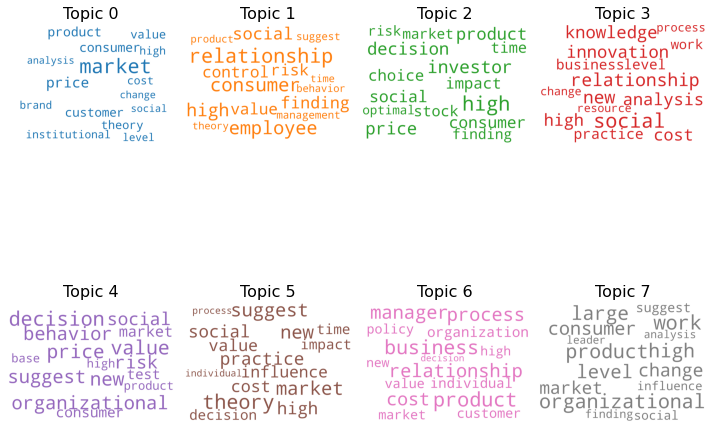

In [350]:
# Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
from matplotlib import cm
from matplotlib.colors import rgb2hex

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()] # more colors: 'mcolors.XKCD_COLORS'
# cols = ['#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231', '#911eb4', '#46f0f0', '#f032e6', '#bcf60c', '#fabebe', '#008080', '#e6beff', '#9a6324', '#fffac8', '#800000', '#aaffc3', '#808000', '#ffd8b1', '#000075', '#808080', '#ffffff', '#000000']

cloud = WordCloud(stopwords=my_stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=15,
                  colormap='tab20',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(12, 15, formatted=False)

fig, axes = plt.subplots(2,4, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')

plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

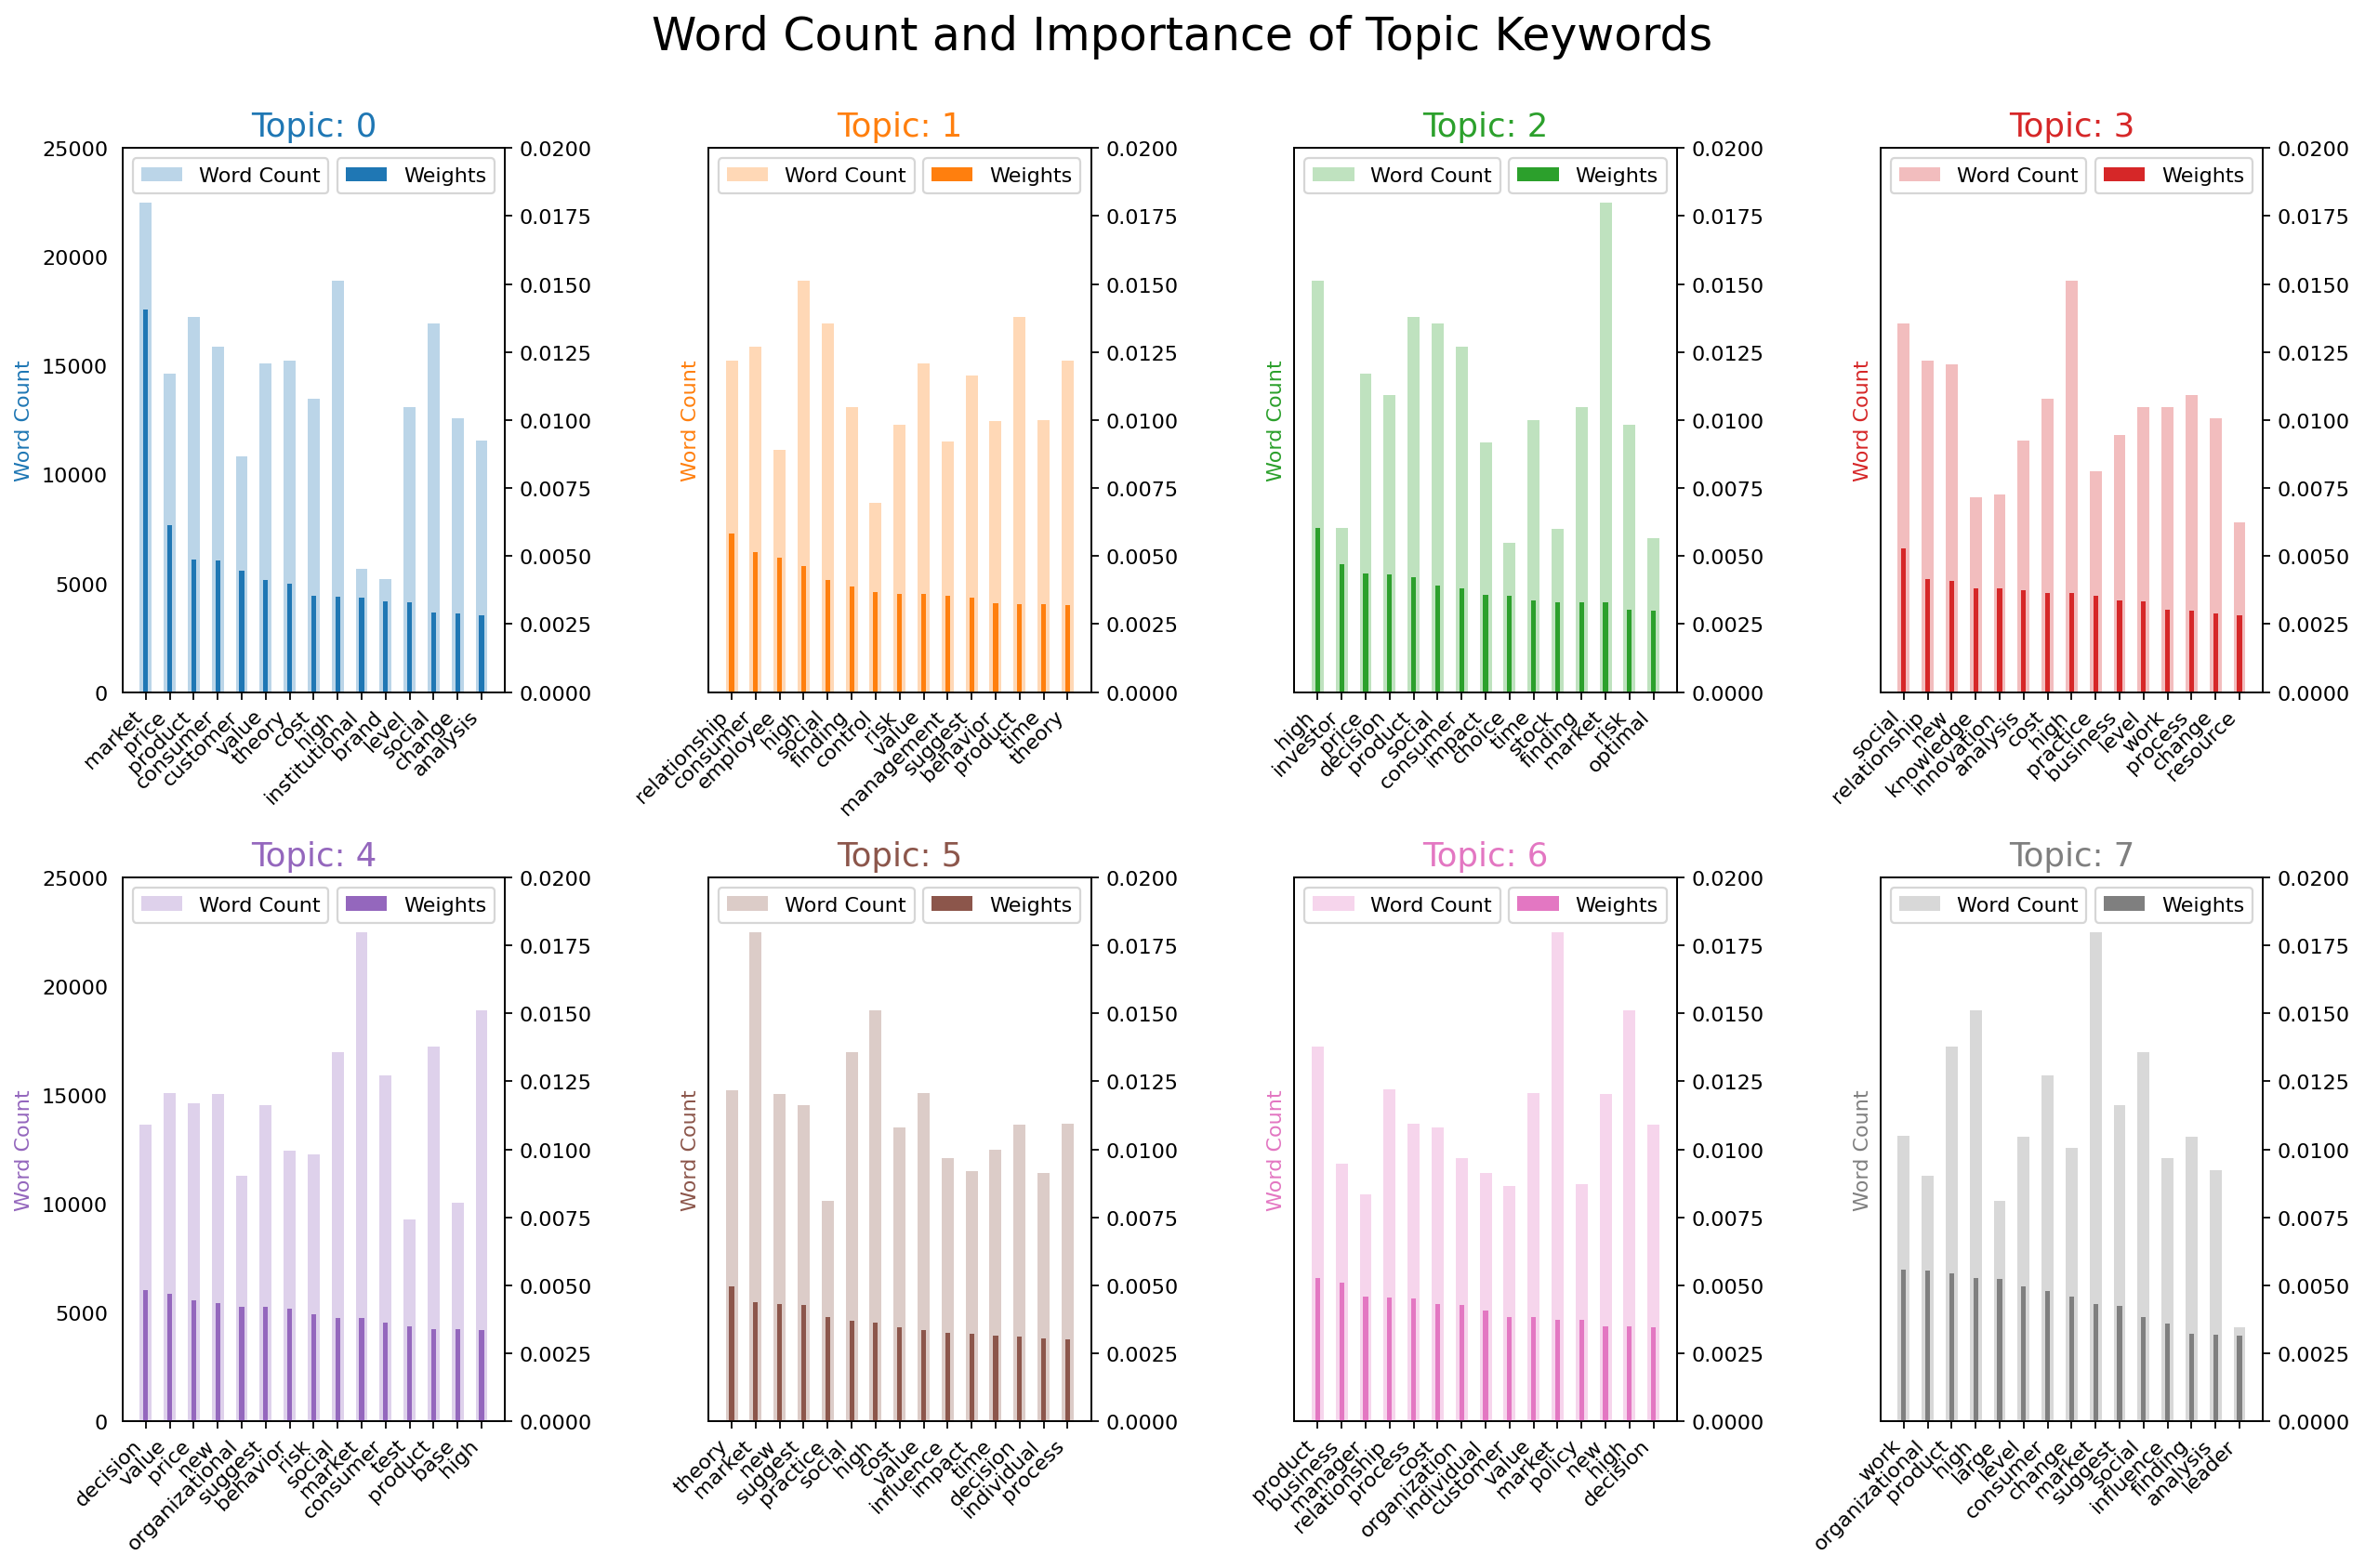

In [351]:
from collections import Counter
import matplotlib.colors as mcolors

topics = lda_model.show_topics(12, 15, formatted=False)
data_flat = [w for w_list in model_calc.abst for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        
# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(2, 4, figsize=(16,10), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.020); ax.set_ylim(0, 25000)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.xaxis.set_ticks(df.loc[df.topic_id==i, 'word'])
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=45, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)    
plt.show()

In [410]:
top_topics = []
keywords = []
for d in model_calc.abst:
    bow = id2word.doc2bow(d)
    t = lda_model.get_document_topics(bow)
    kw = lda_model.get_topic_terms(t[0][0])
    string = []
    for key in kw:
        word = id2word.__getitem__(key[0])
        string.append(word)
    top_topics.append(t[0][0])
    keywords.append(string)

model_calc['topic'] = top_topics
model_calc['keywords'] = [','.join(map(str, l)) for l in keywords]

In [44]:
topics_by_year = model_calc.groupby(['topic','publication_year'])['article_title'].count()
pd.DataFrame(topics_by_year).to_csv('topics_by_year.csv', sep = '\t')

In [413]:
model_calc.to_csv('data_to_model.csv', sep = '\t')

In [374]:
model_calc = model_calc.iloc[:, 0:20]

In [419]:
model_calc.research_areas = model_calc.research_areas.str.split('; ')
model_calc.wos_categories = model_calc.wos_categories.str.split('; ')

In [420]:
test = model_calc.explode('research_areas').pivot_table(index='article_title', columns='research_areas', aggfunc="size", fill_value=0)
model_calc = model_calc.join(test, on='article_title')

test = model_calc.explode('wos_categories').pivot_table(index='article_title', columns='wos_categories', aggfunc='size', fill_value=0)
model_calc = model_calc.join(test, on='article_title', rsuffix='_wos')

In [184]:
# model_calc.rename(columns = {'publication_year':'year'}, inplace = True)
pd.DataFrame(model_calc.groupby(['year','bs_bin','Business & Economics']).size()).to_csv('busecon.csv', sep = '\t')

In [130]:
# Coherence analysis to achieve 11 topics

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from gensim.models import LdaModel, CoherenceModel, LdaMulticore

num_topics = list(range(3,14)[1:])

LDA_models = {}
LDA_topics = {}
for i in num_topics:
  print(i, end=' ')
  LDA_models[i] = LdaModel(corpus=corpus, id2word=id2word, num_topics=i, eval_every=1, chunksize=len(corpus), passes=2, random_state=42)
  print('model built')
  shown_topics = LDA_models[i].show_topics(num_topics=i, num_words=15, formatted=False)
  LDA_topics[i] = [[word[0] for word in topic[1]] for topic in shown_topics]

4 model built
5 model built
6 model built
7 model built
8 model built
9 model built
10 model built
11 model built
12 model built
13 model built


In [131]:
def jaccard_similarity(topic_1, topic_2):
    """
    Derives the Jaccard similarity of two topics

    Jaccard similarity:
    - A statistic used for comparing the similarity and diversity of sample sets
    - J(A,B) = (A ∩ B)/(A ∪ B)
    - Goal is low Jaccard scores for coverage of the diverse elements
    """
    intersection = set(topic_1).intersection(set(topic_2))
    union = set(topic_1).union(set(topic_2))
                    
    return float(len(intersection))/float(len(union))

LDA_stability = {}
for i in range(0, len(num_topics)-1):
    jaccard_sims = []
    for t1, topic1 in enumerate(LDA_topics[num_topics[i]]): # pylint: disable=unused-variable
        sims = []
        for t2, topic2 in enumerate(LDA_topics[num_topics[i+1]]): # pylint: disable=unused-variable
            sims.append(jaccard_similarity(topic1, topic2))    
        
        jaccard_sims.append(sims)    
    
    LDA_stability[num_topics[i]] = jaccard_sims
                
mean_stabilities = [np.array(LDA_stability[i]).mean() for i in num_topics[:-1]]

In [132]:
coherences = [CoherenceModel(model=LDA_models[i], texts=model_calc.abst, dictionary=id2word, coherence='c_v').get_coherence()\
              for i in num_topics[:-1]]

In [133]:
coh_sta_diffs = [coherences[i] - mean_stabilities[i] for i in range(0, len(num_topics)-1)] # limit topic numbers to the number of keywords
coh_sta_max = max(coh_sta_diffs)
coh_sta_max_idxs = [i for i, j in enumerate(coh_sta_diffs) if j == coh_sta_max]
ideal_topic_num_index = coh_sta_max_idxs[0] # choose less topics in case there's more than one max
ideal_topic_num = num_topics[ideal_topic_num_index]

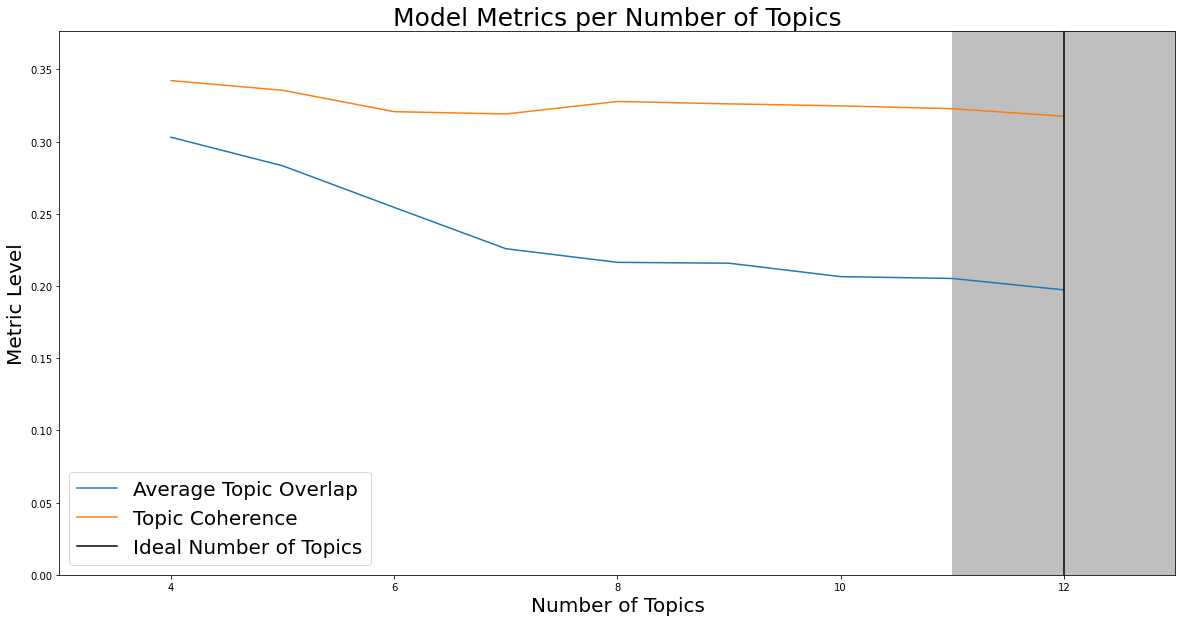

In [134]:
plt.figure(figsize=(20,10))
ax = sns.lineplot(x=num_topics[:-1], y=mean_stabilities, label='Average Topic Overlap')
ax = sns.lineplot(x=num_topics[:-1], y=coherences, label='Topic Coherence')

ax.axvline(x=ideal_topic_num, label='Ideal Number of Topics', color='black')
ax.axvspan(xmin=ideal_topic_num - 1, xmax=ideal_topic_num + 1, alpha=0.5, facecolor='grey')

y_max = max(max(mean_stabilities), max(coherences)) + (0.10 * max(max(mean_stabilities), max(coherences)))
ax.set_ylim([0, y_max])
ax.set_xlim([3, num_topics[-1]])
                
ax.axes.set_title('Model Metrics per Number of Topics', fontsize=25)
ax.set_ylabel('Metric Level', fontsize=20)
ax.set_xlabel('Number of Topics', fontsize=20)
plt.legend(fontsize=20)
plt.show()   